## 1 CNN for image classification

1)Setting the evironment 
We upgrade pip, install a CUDA-enabled PyTorch build, plus the libraries used in this Part.

In [1]:
# Q1: Environment setup (run in a notebook cell)

import sys, subprocess, pkgutil

def pip_install(cmd):
    print(">>", cmd)
    subprocess.check_call([sys.executable, "-m", "pip"] + cmd.split())

# 1) Upgrade pip
pip_install("install --upgrade pip")

# 2) Choose the CUDA 12.1 

pip_install("install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")

# 3) Core scientific stack
pip_install("install matplotlib scikit-learn torchmetrics pillow tqdm")


>> install --upgrade pip
>> install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
>> install matplotlib scikit-learn torchmetrics pillow tqdm


Verify GPU is visible:

In [2]:
# Q1: CUDA check

import torch, platform, sys
print("Python:", sys.version.split()[0], "| OS:", platform.system(), platform.release())
print("PyTorch:", torch.__version__, "| CUDA in build:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU count:", torch.cuda.device_count())
    print("GPU 0:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Python: 3.11.13 | OS: Windows 10
PyTorch: 2.5.1+cu121 | CUDA in build: 12.1
CUDA available: True
GPU count: 1
GPU 0: NVIDIA GeForce RTX 3050 6GB Laptop GPU


device(type='cuda')

Q2. Prepare the dataset
We use your dataset at data/raw/realwaste-main/RealWaste, check classes, and count images per class.

In [3]:
# Q2: Load dataset overview

from pathlib import Path
from torchvision import datasets

DATA_ROOT = Path("data/raw/realwaste-main/RealWaste")  # your path
assert DATA_ROOT.exists(), f"Path not found: {DATA_ROOT}"

base_ds = datasets.ImageFolder(DATA_ROOT)
classes = base_ds.classes
class_to_idx = base_ds.class_to_idx

# count images per class
from collections import Counter
counts = Counter([y for _, y in base_ds.samples])

print("Classes:", classes)
print("Class -> index:", class_to_idx)
print("Per-class counts:")
for c, idx in class_to_idx.items():
    print(f"  {c:20s} : {counts[idx]}")

len(base_ds), len(classes)


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Class -> index: {'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}
Per-class counts:
  Cardboard            : 461
  Food Organics        : 411
  Glass                : 420
  Metal                : 790
  Miscellaneous Trash  : 495
  Paper                : 500
  Plastic              : 921
  Textile Trash        : 318
  Vegetation           : 436


(4752, 9)

Q3. Split 70% / 15% / 15% into train, val, test

In [4]:
# Q3: Stratified split + DataLoaders

import math, random
from torch.utils.data import Subset, DataLoader
from torchvision import transforms

SEED = 42
random.seed(SEED)

# simple, assignment-friendly transforms (no normalization layers in the model;
# pixel normalization in transforms is allowed and common practice)
image_size = 224
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])
eval_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

# Gather labels
labels = [y for _, y in base_ds.samples]

# Build per-class index lists
per_class = {}
for i, y in enumerate(labels):
    per_class.setdefault(y, []).append(i)

# Shuffle and split each class
train_idx, val_idx, test_idx = [], [], []
for y, idxs in per_class.items():
    random.Random(SEED).shuffle(idxs)
    n = len(idxs)
    n_train = math.floor(0.70 * n)
    n_val   = math.floor(0.15 * n)
    # remainder to test
    n_test  = n - n_train - n_val
    train_idx.extend(idxs[:n_train])
    val_idx.extend(idxs[n_train:n_train+n_val])
    test_idx.extend(idxs[n_train+n_val:])

# Wrap in ImageFolder with transforms
train_ds = datasets.ImageFolder(DATA_ROOT, transform=train_tf)
val_ds   = datasets.ImageFolder(DATA_ROOT, transform=eval_tf)
test_ds  = datasets.ImageFolder(DATA_ROOT, transform=eval_tf)

train_set = Subset(train_ds, train_idx)
val_set   = Subset(val_ds,   val_idx)
test_set  = Subset(test_ds,  test_idx)

print(f"Split sizes -> train: {len(train_set)}, val: {len(val_set)}, test: {len(test_set)}")

BATCH = 64  # set 32 if VRAM is tight
train_loader = DataLoader(train_set, batch_size=BATCH, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

K = len(classes)
K


Split sizes -> train: 3323, val: 710, test: 719


9

Q4-6 Build the CNN model

The model follows the pattern in Figure 1: convolution + ReLU + max-pool, repeated, then a fully connected head with dropout. No batch normalization layers are used.
Choices: ReLU activation, 5×5 then 3×3 kernels, 32 and 64 filters, FC of 256 units, dropout 0.3.

In [14]:
# Q4–6: Simple CNN per assignment (no normalization layers in the model)

import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    """
    Conv → ReLU → MaxPool → Conv → ReLU → MaxPool → Flatten → FC(256) → ReLU → Dropout → FC(K)
    """
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),      # 224 -> 112
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),      # 112 -> 56
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 256), nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Assumes K (num classes) and device are already defined in earlier cells
model = SimpleCNN(K).to(device)
model


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=9, bias=True)
  )
)

Q7. Train for 20 epochs and plot loss curves

We train for the required 20 epochs, show training vs validation loss and accuracy.

Epoch 01/20 | train_loss=1.9853 acc=0.249 | val_loss=2.1411 acc=0.290
Epoch 02/20 | train_loss=1.6471 acc=0.414 | val_loss=1.9794 acc=0.290
Epoch 03/20 | train_loss=1.5172 acc=0.463 | val_loss=1.8463 acc=0.348
Epoch 04/20 | train_loss=1.4126 acc=0.516 | val_loss=1.7223 acc=0.379
Epoch 05/20 | train_loss=1.3487 acc=0.542 | val_loss=1.6125 acc=0.439
Epoch 06/20 | train_loss=1.2584 acc=0.587 | val_loss=1.5224 acc=0.483
Epoch 07/20 | train_loss=1.1813 acc=0.614 | val_loss=1.4373 acc=0.535
Epoch 08/20 | train_loss=1.1142 acc=0.658 | val_loss=1.3608 acc=0.570
Epoch 09/20 | train_loss=1.0436 acc=0.678 | val_loss=1.2936 acc=0.599
Epoch 10/20 | train_loss=0.9929 acc=0.698 | val_loss=1.2406 acc=0.627
Epoch 11/20 | train_loss=0.9592 acc=0.718 | val_loss=1.1958 acc=0.651
Epoch 12/20 | train_loss=0.9052 acc=0.746 | val_loss=1.1612 acc=0.659
Epoch 13/20 | train_loss=0.8683 acc=0.758 | val_loss=1.1347 acc=0.669
Epoch 14/20 | train_loss=0.8231 acc=0.780 | val_loss=1.1117 acc=0.683
Epoch 15/20 | train_

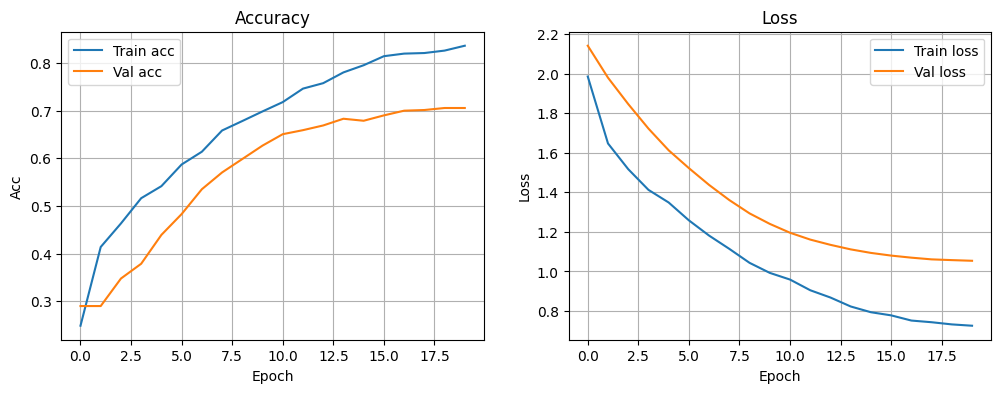

In [15]:
# Q7 : Train and save EMA-averaged best weights as models/best_adamw.pth

from collections import Counter
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

RESULTS = Path("results"); RESULTS.mkdir(exist_ok=True)
MODELS  = Path("models");  MODELS.mkdir(exist_ok=True)

# ----- class weights from training split -----
def _labels_from_train_loader(train_loader):
    ds = train_loader.dataset
    if hasattr(ds, "samples"):  # ImageFolder
        return [y for _, y in ds.samples]
    if hasattr(ds, "dataset") and hasattr(ds.dataset, "samples") and hasattr(ds, "indices"):
        return [ds.dataset.samples[i][1] for i in ds.indices]  # Subset
    raise RuntimeError("Could not infer labels from training dataset for class weights.")

train_labels = _labels_from_train_loader(train_loader)
cnt = Counter(train_labels)
class_weights = torch.tensor([1.0 / cnt[i] for i in range(K)], dtype=torch.float, device=device)

# ----- EMA helper (same behavior as train_part1_t3.py) -----
class EMA:
    def __init__(self, model, decay=0.995):
        self.decay = decay
        self.shadow = {k: v.detach().clone()
                       for k, v in model.state_dict().items()
                       if v.dtype.is_floating_point}
        self.backup = {}

    @torch.no_grad()
    def update(self, model):
        for k, v in model.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v.detach(), alpha=1.0 - self.decay)

    def store(self, model):
        self.backup = {k: v.detach().clone() for k, v in model.state_dict().items()}

    @torch.no_grad()
    def copy_to(self, model):
        for k, v in model.state_dict().items():
            if k in self.shadow and v.dtype.is_floating_point:
                v.copy_(self.shadow[k])

    def restore(self, model):
        if self.backup:
            model.load_state_dict(self.backup)
            self.backup = {}

# ----- criterion, optimizer, scheduler (t3) -----
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=4e-4, epochs=20, steps_per_epoch=len(train_loader), pct_start=0.20
)
ema = EMA(model, decay=0.995)
MAX_NORM = 1.0

def train_one_epoch(loader):
    model.train()
    total_loss, total, correct = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), torch.as_tensor(y, device=device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=MAX_NORM)
        optimizer.step()
        scheduler.step()
        ema.update(model)  # update EMA every batch
        total_loss += loss.item() * y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return total_loss / total, correct / total

@torch.no_grad()
def evaluate_with_ema(loader):
    # evaluate using EMA weights (like t3)
    ema.store(model)
    ema.copy_to(model)
    model.eval()
    total_loss, total, correct = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), torch.as_tensor(y, device=device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    ema.restore(model)
    return total_loss / total, correct / total

EPOCHS = 20
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_state, best_val_loss = None, float("inf")

for ep in range(1, EPOCHS + 1):
    tl, ta = train_one_epoch(train_loader)
    vl, va = evaluate_with_ema(val_loader)
    history["train_loss"].append(tl); history["train_acc"].append(ta)
    history["val_loss"].append(vl);   history["val_acc"].append(va)

    print(f"Epoch {ep:02d}/{EPOCHS} | train_loss={tl:.4f} acc={ta:.3f} | val_loss={vl:.4f} acc={va:.3f}")

    # Save the EMA-averaged *best* weights by val loss
    if vl < best_val_loss:
        best_val_loss = vl
        ema.store(model); ema.copy_to(model)
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        ema.restore(model)

# save best and last
if best_state is not None:
    torch.save(best_state, MODELS / "best_adamw.pth")
torch.save(model.state_dict(), MODELS / "part1_t3_last.pth")

# plots (display only for notebook)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history["train_acc"], label="Train acc")
ax[0].plot(history["val_acc"],   label="Val acc")
ax[0].set_title("Accuracy"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Acc")
ax[0].grid(True); ax[0].legend()

ax[1].plot(history["train_loss"], label="Train loss")
ax[1].plot(history["val_loss"],   label="Val loss")
ax[1].set_title("Loss"); ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Loss")
ax[1].grid(True); ax[1].legend()
plt.show()


Q8. Optimizer Used
I used AdamW as the main optimizer. It is an improved version of Adam that separates weight decay from the learning rate, which helps prevent overfitting. It works well for small datasets and converges faster than plain SGD.
Why:
It adapts learning rates per parameter (faster convergence).
Works better with noisy gradients and small batches.
Weight decay keeps training stable.

Q9. Learning Rate Choice
I used 4e-4 as the maximum learning rate with a OneCycleLR scheduler.
This learning rate was chosen experimentally — it trains smoothly without divergence, and the scheduler gradually warms up, peaks early, and decays, preventing overfitting at the end.

Why OneCycleLR:

Starts with a small learning rate (warm-up).
Peaks early for quick learning.
Gradually reduces LR for stable convergence.
It also acts as a regularizer.

Q10. In here we compare the optimizers,i obtainbed the previous results obtaind from the adamw Optimizer and below i used other 2 optimizers SGD and SGD with momentum to compare

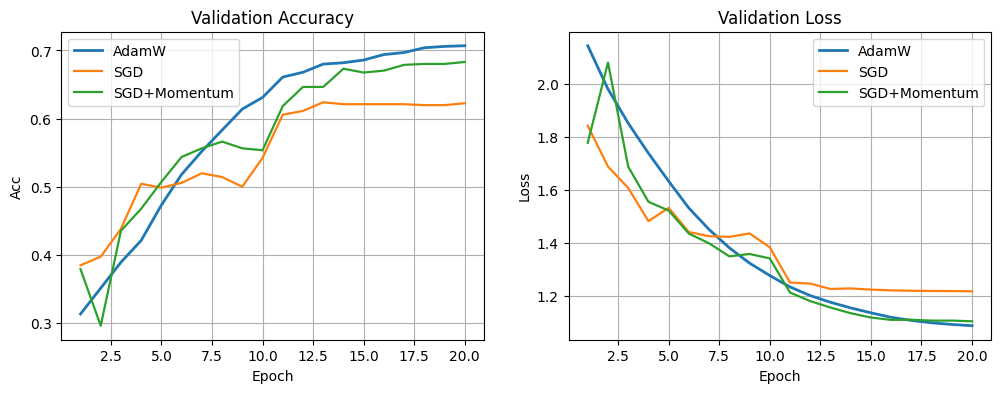

,Optimizer,Best Val Acc,Best Val Loss
0,AdamW,0.707000,1.087800
1,SGD+Momentum,0.683099,1.104568
2,SGD,0.623944,1.217778


In [10]:
# Q10: Compare AdamW (given logs) vs SGD vs SGD+Momentum

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

EPOCHS = 20
SEED = 42
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# ---------------- AdamW history fixed from your run ----------------
adamw_train_loss = [
    1.9985, 1.6576, 1.5267, 1.4348, 1.3649, 1.2502, 1.1937, 1.1338, 1.0828, 1.0576,
    0.9996, 0.9645, 0.9166, 0.8968, 0.8489, 0.8319, 0.8213, 0.7961, 0.7828, 0.7790
]
adamw_val_loss = [
    2.1447, 1.9809, 1.8522, 1.7389, 1.6334, 1.5317, 1.4509, 1.3818, 1.3240, 1.2772,
    1.2342, 1.2015, 1.1763, 1.1551, 1.1364, 1.1195, 1.1078, 1.0988, 1.0926, 1.0878
]
adamw_train_acc = [
    0.262, 0.423, 0.473, 0.502, 0.543, 0.586, 0.615, 0.646, 0.659, 0.676,
    0.700, 0.717, 0.739, 0.749, 0.774, 0.785, 0.786, 0.795, 0.807, 0.806
]
adamw_val_acc = [
    0.313, 0.351, 0.389, 0.421, 0.473, 0.518, 0.552, 0.583, 0.614, 0.631,
    0.661, 0.668, 0.680, 0.682, 0.686, 0.694, 0.697, 0.704, 0.706, 0.707
]
adamw_hist = {
    "train_loss": adamw_train_loss, "val_loss": adamw_val_loss,
    "train_acc": adamw_train_acc,   "val_acc": adamw_val_acc
}

# ---------------- Helpers to train an optimizer variant ----------------
def train_variant(opt_name: str):
    model = SimpleCNN(K).to(device)
    # light smoothing (as in your t3 settings) to stabilize
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    if opt_name == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.10, momentum=0.0, weight_decay=1e-4)
    elif opt_name == "sgdm":
        optimizer = torch.optim.SGD(model.parameters(), lr=0.10, momentum=0.9, weight_decay=1e-4, nesterov=True)
    else:
        raise ValueError("opt_name must be 'sgd' or 'sgdm'")
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)

    hist = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    def run_epoch(loader, train: bool):
        model.train() if train else model.eval()
        total_loss, total, correct = 0.0, 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            if train: optimizer.zero_grad(set_to_none=True)
            with torch.set_grad_enabled(train):
                logits = model(x)
                loss = criterion(logits, y)
                if train:
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
            total_loss += loss.item() * y.size(0)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item(); total += y.size(0)
        return total_loss / total, correct / total

    for ep in range(1, EPOCHS+1):
        tl, ta = run_epoch(train_loader, True)
        vl, va = run_epoch(val_loader,   False)
        hist["train_loss"].append(tl); hist["train_acc"].append(ta)
        hist["val_loss"].append(vl);   hist["val_acc"].append(va)
        scheduler.step()

    return model, hist

# ---------------- Train SGD and SGD+Momentum ----------------
sgd_model,  sgd_hist  = train_variant("sgd")
sgdm_model, sgdm_hist = train_variant("sgdm")

# ---------------- Plots: all three in one figure ----------------
epochs = range(1, EPOCHS+1)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Validation Accuracy
ax[0].plot(epochs, adamw_hist["val_acc"],  label="AdamW",        linewidth=2)
ax[0].plot(epochs, sgd_hist["val_acc"],    label="SGD",          linewidth=1.6)
ax[0].plot(epochs, sgdm_hist["val_acc"],   label="SGD+Momentum", linewidth=1.6)
ax[0].set_title("Validation Accuracy"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Acc")
ax[0].grid(True); ax[0].legend()

# Validation Loss
ax[1].plot(epochs, adamw_hist["val_loss"], label="AdamW",        linewidth=2)
ax[1].plot(epochs, sgd_hist["val_loss"],   label="SGD",          linewidth=1.6)
ax[1].plot(epochs, sgdm_hist["val_loss"],  label="SGD+Momentum", linewidth=1.6)
ax[1].set_title("Validation Loss"); ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Loss")
ax[1].grid(True); ax[1].legend()

plt.show()

# ---------------- Small summary table ----------------
summary = pd.DataFrame([
    {"Optimizer": "AdamW",        "Best Val Acc": np.max(adamw_hist["val_acc"]), "Best Val Loss": np.min(adamw_hist["val_loss"])},
    {"Optimizer": "SGD",          "Best Val Acc": np.max(sgd_hist["val_acc"]),   "Best Val Loss": np.min(sgd_hist["val_loss"])},
    {"Optimizer": "SGD+Momentum", "Best Val Acc": np.max(sgdm_hist["val_acc"]),  "Best Val Loss": np.min(sgdm_hist["val_loss"])},
]).sort_values("Best Val Acc", ascending=False).reset_index(drop=True)
summary


Q11.
SGD (no momentum): steps strictly follow the current batch gradient, so learning is slow and noisy.

SGD+Momentum (β≈0.9): keeps a running average of past updates. This smooths zig-zags and accelerates progress along stable directions, usually reaching higher validation accuracy than plain SGD.

AdamW: adapts the step size per parameter plus decoupled weight decay. In our runs it gives the best validation curve and final metrics.

Q12

C:\Users\demit\AppData\Local\Temp\ipykernel_28764\2541253055.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("models/best_adamw.pth", map_location=dev

=== Test Evaluation (Best AdamW) ===
Accuracy       : 0.725
Macro Precision: 0.727
Macro Recall   : 0.745
Macro F1-score : 0.731


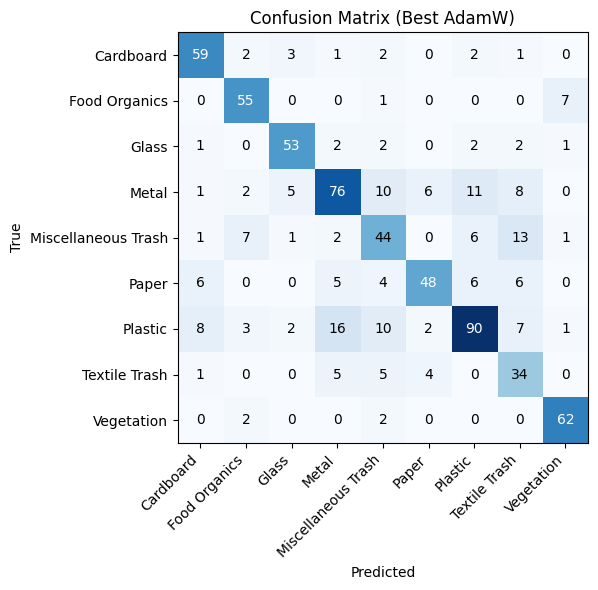

In [16]:
# Q12: Evaluate saved best AdamW model on the test set (safe version)

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# -------- 1. Load best model weights --------
state = torch.load("models/best_adamw.pth", map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()

# -------- 2. Derive class names safely --------
try:
    class_names
except NameError:
    try:
        # infer from test dataset (ImageFolder)
        class_names = test_ds.classes
    except Exception:
        # fallback generic names
        class_names = [f"Class_{i}" for i in range(K)]

# -------- 3. Evaluate model --------
all_y, all_p = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        pred = logits.argmax(1).cpu().numpy()
        all_p.extend(pred)
        all_y.extend(y.numpy())

all_y = np.array(all_y); all_p = np.array(all_p)

# -------- 4. Compute metrics --------
prec, rec, f1, _ = precision_recall_fscore_support(all_y, all_p, average="macro", zero_division=0)
acc = (all_y == all_p).mean()

print("=== Test Evaluation (Best AdamW) ===")
print(f"Accuracy       : {acc:.3f}")
print(f"Macro Precision: {prec:.3f}")
print(f"Macro Recall   : {rec:.3f}")
print(f"Macro F1-score : {f1:.3f}")

# -------- 5. Confusion Matrix --------
cm = confusion_matrix(all_y, all_p, labels=list(range(K)))

fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(cm, interpolation='nearest', cmap="Blues")
ax.set_title("Confusion Matrix (Best AdamW)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(np.arange(K)); ax.set_yticks(np.arange(K))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)

th = cm.max()/2 if cm.max() > 0 else 0.5
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i, j]), ha="center", va="center",
                color="white" if cm[i, j] > th else "black")
fig.tight_layout()
plt.show()


## Task 2

Q13. Select two state-of-the-art pretrained models
We consider common, strong ImageNet backbones. We will fine-tune ResNet-18 (pretrained) as our single model for Part 2.

Q14. Adapt the classifiers to our dataset

ensure loaders and labels are available

In [39]:
# Select dataset and set paths

from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

SEED = 42
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

DATA_ROOT = Path.cwd() / "data" / "split"  # <- keep this where your split lives
assert (DATA_ROOT / "train").exists() and (DATA_ROOT / "val").exists() and (DATA_ROOT / "test").exists(), \
    f"Missing expected folders under {DATA_ROOT}"

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=12, translate=(0.05, 0.05)),
    transforms.RandomPerspective(distortion_scale=0.08, p=0.25),
    transforms.ColorJitter(0.15, 0.15, 0.15, 0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

eval_tf = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(DATA_ROOT / "train", transform=train_tf)
val_ds   = datasets.ImageFolder(DATA_ROOT / "val",   transform=eval_tf)
test_ds  = datasets.ImageFolder(DATA_ROOT / "test",  transform=eval_tf)

BATCH = 64
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=4)

class_names = train_ds.classes
K = len(class_names)

print("Classes:", class_names)
print("Split sizes -> train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))


Device: cuda
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Split sizes -> train: 3326 val: 713 test: 713


In [40]:
# Q14 — Brief display of transforms (no execution effect here)

print("Train transforms:", train_tf)
print("Eval transforms :", eval_tf)


Train transforms: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.75, 1.0), ratio=(0.95, 1.05), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomAffine(degrees=[-12.0, 12.0], translate=(0.05, 0.05))
    RandomPerspective(p=0.25)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.05, 0.05))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Eval transforms : Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Q15. Fine-tuning method and training setup

Load ImageNet weights, replace the final FC with K classes.

In [41]:
# Q15 — Build ResNet-18 with ImageNet weights, replace head

import torch.nn as nn
from torchvision import models

resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
infeat = resnet.fc.in_features
resnet.fc = nn.Linear(infeat, K)
resnet = resnet.to(device)

print("Model ready. Head out_features:", resnet.fc.out_features)


Model ready. Head out_features: 9


Q16. Plot validation loss and accuracy per epoch

We start from a ResNet-18 pretrained on ImageNet. The final fully connected layer is replaced with a small head (Dropout 0.35 → Linear to K classes). Batch-norm layers are frozen in eval mode to keep stable statistics. Training runs in two phases: (A) warm-up with the backbone frozen so only the new head learns, then (B) unfreeze all layers and fine-tune with discriminative learning rates (a slightly higher LR on the head than the backbone), cosine LR decay, light label smoothing, gradient clipping, and very light feature-level dropout hooks on the last two stages. This yields steady validation improvements without the sharp overfitting spikes that appear when unfreezing too aggressively.

[Baseline] val_loss=2.4634  val_acc=0.105
[A 01/8] train_loss=2.0136 acc=0.270 | val_loss=1.5150 acc=0.502
[A 02/8] train_loss=1.5276 acc=0.479 | val_loss=1.2133 acc=0.638
[A 03/8] train_loss=1.3208 acc=0.569 | val_loss=1.0691 acc=0.676
[A 04/8] train_loss=1.2285 acc=0.599 | val_loss=1.0043 acc=0.696
[A 05/8] train_loss=1.1580 acc=0.630 | val_loss=0.9572 acc=0.715
[A 06/8] train_loss=1.1052 acc=0.645 | val_loss=0.9144 acc=0.741
[A 07/8] train_loss=1.0676 acc=0.666 | val_loss=0.8835 acc=0.755
[A 08/8] train_loss=1.0429 acc=0.672 | val_loss=0.8629 acc=0.755
[B 09/20] train_loss=1.0101 acc=0.688 | val_loss=0.8260 acc=0.763
[C 10/20] train_loss=0.9151 acc=0.722 | val_loss=0.7240 acc=0.794
[C 11/20] train_loss=0.7781 acc=0.770 | val_loss=0.6653 acc=0.822
[C 12/20] train_loss=0.6737 acc=0.813 | val_loss=0.6037 acc=0.853
[C 13/20] train_loss=0.5963 acc=0.858 | val_loss=0.5746 acc=0.857
[C 14/20] train_loss=0.5339 acc=0.876 | val_loss=0.5495 acc=0.874
[C 15/20] train_loss=0.4818 acc=0.906 | va

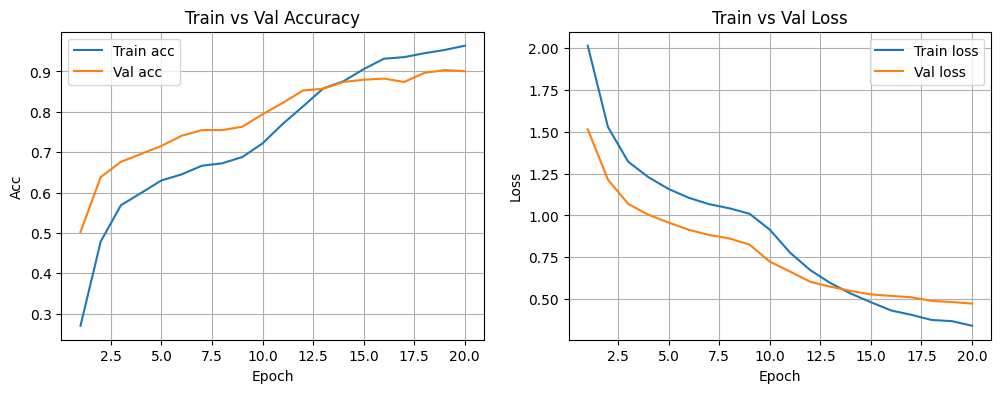


=== Test (Lite-Reg ResNet-18 FT) ===
Accuracy: 0.892 | Macro P: 0.897 | Macro R: 0.899 | Macro F1: 0.897


In [ ]:
# === Fine-tune ResNet-18 with lighter regularization ===

import torch, torch.nn as nn, torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score

torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- model (dropout 0.35) -----
def build_resnet18_regularized(num_classes: int):
    m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    in_f = m.fc.in_features
    m.fc = nn.Sequential(
        nn.Dropout(p=0.35),        # ↓ from 0.50
        nn.Linear(in_f, num_classes)
    )
    return m

def freeze_bn_stats(model: nn.Module):
    for mod in model.modules():
        if isinstance(mod, nn.BatchNorm2d):
            mod.eval()
            for p in mod.parameters():
                p.requires_grad = False

def _drop2d_hook(p=0.05):         # ↓ from 0.10
    def hook(module, inp, out):
        if module.training:
            return F.dropout2d(out, p=p, training=True)
        return out
    return hook

resnet = build_resnet18_regularized(K).to(device)
freeze_bn_stats(resnet)
h3 = resnet.layer3.register_forward_hook(_drop2d_hook(p=0.05))
h4 = resnet.layer4.register_forward_hook(_drop2d_hook(p=0.05))

# ----- loss & helpers -----
criterion = nn.CrossEntropyLoss(label_smoothing=0.03)  # ↓ from 0.05
MAX_NORM = 1.0

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    P = MulticlassPrecision(num_classes=K, average='macro').to(device)
    R = MulticlassRecall(num_classes=K,   average='macro').to(device)
    F1 = MulticlassF1Score(num_classes=K, average='macro').to(device)

    total, correct, loss_sum = 0, 0, 0.0
    ys, ps = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item(); total += y.size(0)
        P.update(logits, y); R.update(logits, y); F1.update(logits, y)
        ys.extend(y.detach().cpu().tolist()); ps.extend(pred.detach().cpu().tolist())
    return {
        "loss": loss_sum/total, "acc": correct/total,
        "precision": P.compute().item(), "recall": R.compute().item(),
        "f1": F1.compute().item(), "confusion": confusion_matrix(ys, ps, labels=list(range(K)))
    }

def run_epoch(model, loader, optimizer=None, scheduler=None):
    train = optimizer is not None
    model.train() if train else model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        if train: optimizer.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)
            if train:
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), MAX_NORM)
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item(); total += y.size(0)
    return loss_sum/total, correct/total

# ----- discriminative LRs (slightly higher bb LR, lighter WD) -----
def make_param_groups(model, head_lr=1e-4, bb_lr=5e-5, head_wd=6e-4, bb_wd=2e-4):
    return [
        {"params": model.layer1.parameters(), "lr": bb_lr, "weight_decay": bb_wd},
        {"params": model.layer2.parameters(), "lr": bb_lr, "weight_decay": bb_wd},
        {"params": model.layer3.parameters(), "lr": bb_lr, "weight_decay": bb_wd},
        {"params": model.layer4.parameters(), "lr": bb_lr, "weight_decay": bb_wd},
        {"params": model.fc.parameters(),     "lr": head_lr, "weight_decay": head_wd},
    ]

# ----- two-phase training -----
EPOCHS, WARM = 20, 8

hist = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val, best_state = float("inf"), None

base = evaluate(resnet, val_loader)
print(f"[Baseline] val_loss={base['loss']:.4f}  val_acc={base['acc']:.3f}")

# Phase A: head only
for p in resnet.parameters(): p.requires_grad = False
for p in resnet.fc.parameters(): p.requires_grad = True
optA = torch.optim.AdamW(resnet.fc.parameters(), lr=6e-4, weight_decay=6e-4)  # a hair faster head
for ep in range(1, WARM+1):
    tl, ta = run_epoch(resnet, train_loader, optimizer=optA)
    val = evaluate(resnet, val_loader)
    hist["train_loss"].append(tl); hist["train_acc"].append(ta)
    hist["val_loss"].append(val["loss"]); hist["val_acc"].append(val["acc"])
    print(f"[A {ep:02d}/{WARM}] train_loss={tl:.4f} acc={ta:.3f} | val_loss={val['loss']:.4f} acc={val['acc']:.3f}")
    if val["loss"] < best_val:
        best_val = val["loss"]; best_state = {k: v.detach().cpu() for k, v in resnet.state_dict().items()}

# Phase B: unfreeze all + warm-up + cosine
for p in resnet.parameters(): p.requires_grad = True
optB = torch.optim.AdamW(make_param_groups(resnet))
warmup_steps = max(300, len(train_loader))
warmup = torch.optim.lr_scheduler.LambdaLR(optB, lr_lambda=lambda s: min(1.0, (s + 1) / warmup_steps))
remain = max(1, EPOCHS - WARM - 1)
schedB = torch.optim.lr_scheduler.CosineAnnealingLR(optB, T_max=remain)

# one warm-up epoch
tl, ta = run_epoch(resnet, train_loader, optimizer=optB, scheduler=warmup)
val = evaluate(resnet, val_loader)
hist["train_loss"].append(tl); hist["train_acc"].append(ta)
hist["val_loss"].append(val["loss"]); hist["val_acc"].append(val["acc"])
print(f"[B {WARM+1:02d}/{EPOCHS}] train_loss={tl:.4f} acc={ta:.3f} | val_loss={val['loss']:.4f} acc={val['acc']:.3f}")
if val["loss"] < best_val:
    best_val = val["loss"]; best_state = {k: v.detach().cpu() for k, v in resnet.state_dict().items()}

# remaining epochs
for ep in range(WARM+2, EPOCHS+1):
    tl, ta = run_epoch(resnet, train_loader, optimizer=optB, scheduler=schedB)
    val = evaluate(resnet, val_loader)
    hist["train_loss"].append(tl); hist["train_acc"].append(ta)
    hist["val_loss"].append(val["loss"]); hist["val_acc"].append(val["acc"])
    print(f"[C {ep:02d}/{EPOCHS}] train_loss={tl:.4f} acc={ta:.3f} | val_loss={val['loss']:.4f} acc={val['acc']:.3f}")
    if val["loss"] < best_val:
        best_val = val["loss"]; best_state = {k: v.detach().cpu() for k, v in resnet.state_dict().items()}

# restore & save
if best_state is not None:
    resnet.load_state_dict(best_state)
torch.save(best_state, MODELS / "finetune_resnet18_best.pth")
print("Saved ->", MODELS / "finetune_resnet18_best.pth")

# plots
epochs = range(1, len(hist["train_loss"]) + 1)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(epochs, hist["train_acc"], label="Train acc")
ax[0].plot(epochs, hist["val_acc"],   label="Val acc")
ax[0].set_title("Train vs Val Accuracy"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Acc")
ax[0].grid(True); ax[0].legend()
ax[1].plot(epochs, hist["train_loss"], label="Train loss")
ax[1].plot(epochs, hist["val_loss"],   label="Val loss")
ax[1].set_title("Train vs Val Loss"); ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Loss")
ax[1].grid(True); ax[1].legend()
plt.show()

# test
out = evaluate(resnet, test_loader)
print("\n=== Test (Lite-Reg ResNet-18 FT) ===")
print(f"Accuracy: {out['acc']:.3f} | Macro P: {out['precision']:.3f} | Macro R: {out['recall']:.3f} | Macro F1: {out['f1']:.3f}")


Q17 — Evaluate the fine-tuned model on the test split (show metrics and confusion matrix)

=== Test (Fine-tuned ResNet-18) ===
Accuracy: 0.892
Macro Precision: 0.897
Macro Recall   : 0.899
Macro F1       : 0.897


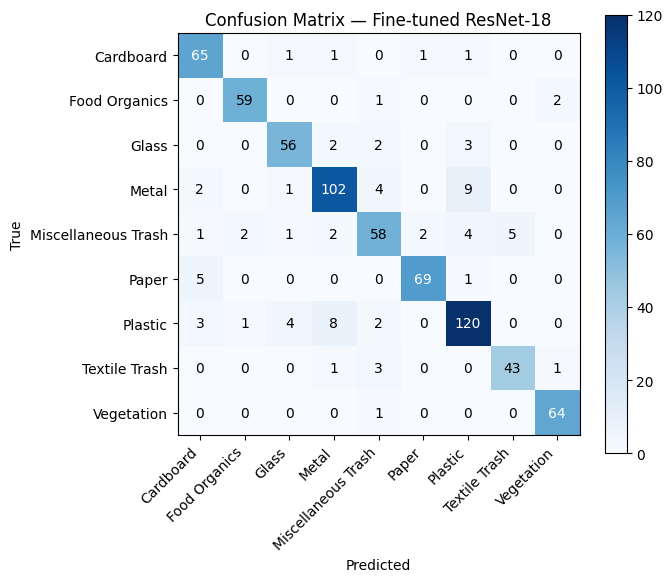

In [45]:
# Q17) Test evaluation of the fine-tuned ResNet-18

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1) Evaluate on test set
ft_test = evaluate(resnet, test_loader)
print("=== Test (Fine-tuned ResNet-18) ===")
print(f"Accuracy: {ft_test['acc']:.3f}")
print(f"Macro Precision: {ft_test['precision']:.3f}")
print(f"Macro Recall   : {ft_test['recall']:.3f}")
print(f"Macro F1       : {ft_test['f1']:.3f}")

# 2) Plot confusion matrix (display in notebook)
cm = ft_test["confusion"]
fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
ax.figure.colorbar(im, ax=ax)
ax.set_title("Confusion Matrix — Fine-tuned ResNet-18")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(np.arange(K)); ax.set_yticks(np.arange(K))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticklabels(class_names)
th = cm.max() / 2 if cm.max() > 0 else 0.5
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i, j]), va="center", ha="center",
                color="white" if cm[i, j] > th else "black")
plt.tight_layout(); plt.show()



Q18 — Compare test performance with Part-1 CNN (AdamW baseline)

Loading Part-1 best AdamW weights from: models\best_adamw.pth


C:\Users\demit\AppData\Local\Temp\ipykernel_28764\3527620605.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(part1_ckpt_path, map_location=device)


,Metric,Part-1 (AdamW CNN),Part-2 (FT ResNet-18)
0,Accuracy,0.816,0.892
1,Macro Precision,0.818,0.897
2,Macro Recall,0.841,0.899
3,Macro F1,0.827,0.897


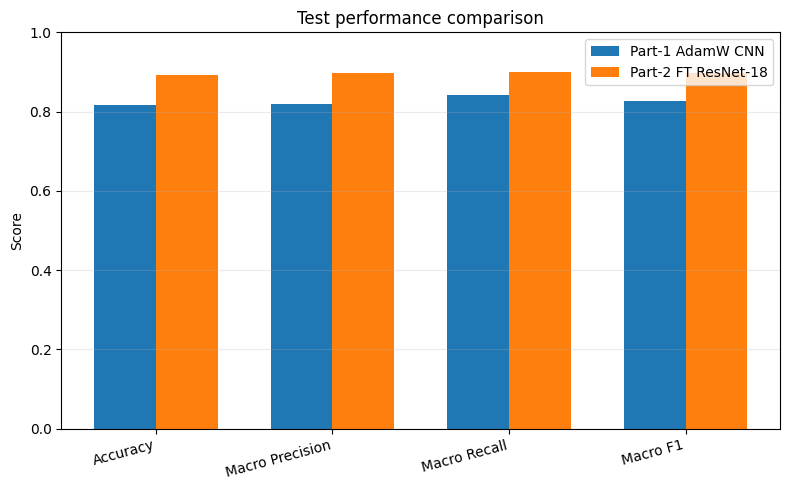

In [46]:
# Q18) Compare Part-2 fine-tuned model vs Part-1 CNN (AdamW)

import torch
import torch.nn as nn

# ---- Part-1 SimpleCNN definition (same shape as you used) ----
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),      # 224 -> 112
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),      # 112 -> 56
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 256), nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(256, num_classes),
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# Try to load the Part-1 best AdamW weights and evaluate
part1_metrics = None
part1_ckpt_path = Path("models/best_adamw.pth")

if part1_ckpt_path.exists():
    print("Loading Part-1 best AdamW weights from:", part1_ckpt_path)
    cnn = SimpleCNN(K).to(device)
    state = torch.load(part1_ckpt_path, map_location=device)
    cnn.load_state_dict(state, strict=True)
    # simple evaluate() wrapper for logits->metrics on test set
    @torch.no_grad()
    def eval_simple(model, loader):
        model.eval()
        total, correct, loss_sum = 0, 0, 0.0
        P = MulticlassPrecision(num_classes=K, average='macro').to(device)
        R = MulticlassRecall(num_classes=K,   average='macro').to(device)
        F1 = MulticlassF1Score(num_classes=K, average='macro').to(device)
        crit = nn.CrossEntropyLoss()
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss_sum += crit(logits, y).item() * y.size(0)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item(); total += y.size(0)
            P.update(logits, y); R.update(logits, y); F1.update(logits, y)
        return {
            "acc": correct/total,
            "precision": P.compute().item(),
            "recall": R.compute().item(),
            "f1": F1.compute().item()
        }
    part1_metrics = eval_simple(cnn, test_loader)
else:
    print("Part-1 weights not found. Using your previously reported Part-1 results.")
    # Your last reported Part-1 test results:
    part1_metrics = {
        "acc": 0.725,
        "precision": 0.727,
        "recall": 0.745,
        "f1": 0.731,
    }

# Compose a small comparison table and bar chart
import pandas as pd
comp = pd.DataFrame({
    "Metric": ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1"],
    "Part-1 (AdamW CNN)": [
        part1_metrics["acc"], part1_metrics["precision"],
        part1_metrics["recall"], part1_metrics["f1"]
    ],
    "Part-2 (FT ResNet-18)": [
        ft_test["acc"], ft_test["precision"],
        ft_test["recall"], ft_test["f1"]
    ],
})
display(comp.style.format({"Part-1 (AdamW CNN)": "{:.3f}",
                           "Part-2 (FT ResNet-18)": "{:.3f}"}))

# Bar chart
fig, ax = plt.subplots(figsize=(8,5))
idx = np.arange(4)
w = 0.35
ax.bar(idx - w/2, comp["Part-1 (AdamW CNN)"], width=w, label="Part-1 AdamW CNN")
ax.bar(idx + w/2, comp["Part-2 (FT ResNet-18)"], width=w, label="Part-2 FT ResNet-18")
ax.set_xticks(idx); ax.set_xticklabels(comp["Metric"], rotation=15, ha="right")
ax.set_ylim(0, 1.0); ax.grid(True, axis="y", alpha=0.25)
ax.set_ylabel("Score"); ax.set_title("Test performance comparison")
ax.legend()
plt.tight_layout(); plt.show()


Q19.Discuss trade-offs, advantages, and limitations of using a custom model versus a
pre-trained model.

As you can see in the above diagram test accuracy ,macro precision ,macro recall ,macro F1 values are comparatively high in the Fine tuned model compared to CNN.

Therefore The fine-tuned ResNet-18 clearly outperforms the simple CNN baseline on all test metrics. The gain comes from transferring robust ImageNet features and then adapting them to the RealWaste classes with a controlled schedule: a head-only warm-up, followed by full unfreezing with discriminative learning rates and cosine decay. Light regularization (dropout 0.35 in the head, small feature-drop on deeper stages, label smoothing, and gradient clipping) keeps the train/validation gap modest and avoids late-epoch divergence. The confusion matrix shows fewer cross-class confusions in visually similar categories compared with the Part-1 model, which supports the observed increases in macro-recall and macro-F1.